In [ ]:
!pip install opencv-python-headless

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import zipfile
import os

# Путь к архиву (укажите путь к вашему архиву)
zip_file_path = '/home/jovyan/your_archive.zip'  # Замените на путь вашего архива

# Папка, в которую разархивировать содержимое
output_dir = '/home/jovyan/unzipped_folder/'  # Папка, в которую будет распакован архив

# Убедимся, что папка существует
os.makedirs(output_dir, exist_ok=True)

# Разархивируем
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Архив {zip_file_path} успешно разархивирован в {output_dir}")

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [ ]:
import os
import shutil
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
import zipfile
from IPython.display import FileLink, display

# Установка устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Инициализация модели SAM2
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"  # Убедитесь, что путь корректен
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"           # Убедитесь, что путь корректен

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders=True):
    """
    Отображает маску на изображении.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # Голубой цвет с прозрачностью
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01 * cv2.arcLength(contour, True), closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_box(box, ax, color='green', linewidth=2):
    """
    Отображает прямоугольник (бокс) на изображении.
    """
    x0, y0, x1, y1 = box
    w, h = x1 - x0, y1 - y0
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor=(0, 0, 0, 0), lw=linewidth))

def show_masks(image, masks, old_boxes, new_boxes, ax):
    """
    Отображает изображение с наложенными масками и боксами.
    """
    ax.imshow(image)
    for mask in masks:
        show_mask(mask, ax, random_color=True, borders=True)
    for box in old_boxes:
        show_box(box, ax, color='red', linewidth=2)  # Исходные боксы
    for box in new_boxes:
        show_box(box, ax, color='green', linewidth=2)  # Скорректированные боксы
    ax.axis('off')

def refine_box(mask):
    """
    Уточняет бокс на основе маски сегментации.

    Параметры:
        mask (np.ndarray): Маска сегментации.

    Возвращает:
        list или None: Уточнённый бокс [x_min, y_min, x_max, y_max] или None, если контуры не найдены.
    """
    # Бинаризация маски
    mask = (mask > 0).astype(np.uint8) * 255
    print(f"Processing mask with shape: {mask.shape}, unique values: {np.unique(mask)}")
    
    # Поиск контуров
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours found: {len(contours)}")
    
    if not contours:
        return None
    
    # Объединяем все контуры
    all_contours = np.vstack(contours)
    x, y, w, h = cv2.boundingRect(all_contours)
    return [x, y, x + w, y + h]

def expand_box(box, img_width, img_height, expansion_ratio=0.1):
    """
    Увеличивает бокс на заданный процент от его размера.

    Параметры:
        box (list): [x_min, y_min, x_max, y_max]
        img_width (int): Ширина изображения.
        img_height (int): Высота изображения.
        expansion_ratio (float): Процент увеличения (0.1 означает 10%).

    Возвращает:
        list: Расширенный бокс [new_x_min, new_y_min, new_x_max, new_y_max].
    """
    x_min, y_min, x_max, y_max = box
    box_width = x_max - x_min
    box_height = y_max - y_min

    # Вычисляем увеличение
    delta_w = int(box_width * expansion_ratio)
    delta_h = int(box_height * expansion_ratio)

    # Новые координаты с учётом увеличения
    new_x_min = max(0, x_min - delta_w)
    new_y_min = max(0, y_min - delta_h)
    new_x_max = min(img_width - 1, x_max + delta_w)
    new_y_max = min(img_height - 1, y_max + delta_h)

    return [new_x_min, new_y_min, new_x_max, new_y_max]

def boxes_to_yolo_format(boxes, img_width, img_height, class_id=0):
    """
    Конвертирует боксы из формата [x_min, y_min, x_max, y_max] в формат YOLO.

    Параметры:
        boxes (list): Список боксов [x_min, y_min, x_max, y_max].
        img_width (int): Ширина изображения.
        img_height (int): Высота изображения.
        class_id (int): Идентификатор класса.

    Возвращает:
        list: Список аннотаций в формате YOLO.
    """
    yolo_annotations = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height
        yolo_annotations.append([class_id, x_center, y_center, width, height])
    return yolo_annotations

def process_image(image_path, label_path, corrected_label_path, predictor, device):
    """
    Обрабатывает одно изображение и соответствующий ему файл разметки.

    Параметры:
        image_path (str): Путь к изображению.
        label_path (str): Путь к файлу разметки YOLO.
        corrected_label_path (str): Путь для сохранения скорректированного файла разметки.
        predictor (SAM2ImagePredictor): Объект предиктора SAM2.
        device (torch.device): Устройство (GPU или CPU).
    """
    # Загрузка изображения
    try:
        image = Image.open(image_path)
        image = np.array(image.convert("RGB"))
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return

    # Размеры изображения
    img_height, img_width = image.shape[:2]

    # Чтение YOLO-аннотаций из файла
    input_boxes = []
    input_labels = []
    label_counter = 0

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                yolo_data = line.strip().split()
                if len(yolo_data) < 5:
                    continue  # Пропустить некорректные строки
                _, x_center, y_center, width, height = map(float, yolo_data)

                # Преобразование относительных координат в абсолютные
                x_center_abs = x_center * img_width
                y_center_abs = y_center * img_height
                width_abs = width * img_width
                height_abs = height * img_height

                # Вычисляем новые угловые координаты (x_min, y_min, x_max, y_max) с расширением
                x_min = int(x_center_abs - width_abs / 2)
                y_min = int(y_center_abs - height_abs / 2)
                x_max = int(x_center_abs + width_abs / 2)
                y_max = int(y_center_abs + height_abs / 2)

                # Убедимся, что боксы не выходят за границы изображения
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(img_width - 1, x_max)
                y_max = min(img_height - 1, y_max)

                # Увеличение бокса на 10%
                expanded_box = expand_box([x_min, y_min, x_max, y_max], img_width, img_height, expansion_ratio=0.1)
                input_boxes.append(expanded_box)

                # Добавляем метку для текущего бокса
                input_labels.append(label_counter)
                label_counter += 1

    # Если файл разметки пустой или отсутствует, просто копируем его
    if not input_boxes:
        if os.path.exists(label_path):
            shutil.copy(label_path, corrected_label_path)
            print(f"Copied empty or non-existent label file: {label_path} to {corrected_label_path}")
        else:
            # Создаём пустой файл
            open(corrected_label_path, 'w').close()
            print(f"Created empty label file: {corrected_label_path}")
        return

    # Преобразуем списки в numpy массивы для удобства использования
    input_boxes = np.array(input_boxes)
    input_labels = np.array(input_labels)

    # Установка изображения в предиктор SAM2
    predictor.set_image(image)

    # Прогноз масок
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )
    masks = masks[:,0]

    # Инициализация списка для новых боксов
    new_boxes = []

    for i, mask in enumerate(masks):
        # Обработка маски
        mask_np = (mask > 0).astype(np.uint8) * 255

        # Отладочная визуализация маски (можно закомментировать после отладки)
        #plt.figure()
        #plt.imshow(mask_np, cmap='gray')
        #plt.title(f"Mask {i+1}")
        #plt.show()

        # Уточнение бокса
        refined_box = refine_box(mask_np)
        if refined_box:
            new_boxes.append(refined_box)

    # Визуализация результатов (можно закомментировать для ускорения)
    #plt.figure(figsize=(10, 10))
    #ax = plt.gca()
    #show_masks(image, masks, input_boxes, new_boxes, ax)
    #plt.show()

    # Конвертация новых боксов в формат YOLO
    yolo_annotations = boxes_to_yolo_format(new_boxes, img_width, img_height, class_id=0)
    print("New Boxes:", new_boxes)
    print("YOLO Annotations:", yolo_annotations)

    # Проверка наличия аннотаций
    if yolo_annotations:
        # Запись аннотаций в файл
        with open(corrected_label_path, 'w') as f:
            for annotation in yolo_annotations:
                annotation_str = ' '.join([str(annotation[0]), 
                                           f"{annotation[1]:.6f}", 
                                           f"{annotation[2]:.6f}", 
                                           f"{annotation[3]:.6f}", 
                                           f"{annotation[4]:.6f}"])
                f.write(f"{annotation_str}\n")
        print(f"Processed and saved corrected labels for image: {image_path}")

        # Чтение и вывод содержимого файла для проверки
        with open(corrected_label_path, 'r') as f:
            content = f.read()
            print(f"Contents of {corrected_label_path}:\n{content}")
    else:
        print(f"No YOLO annotations generated for image: {image_path}")

def process_folder(input_folder, output_folder, predictor, device):
    """
    Обрабатывает все изображения и соответствующие файлы разметки в папке.

    Параметры:
        input_folder (str): Путь к исходной папке с подкаталогами 'images' и 'labels'.
        output_folder (str): Путь к новой папке, где будут сохранены скорректированные файлы.
        predictor (SAM2ImagePredictor): Объект предиктора SAM2.
        device (torch.device): Устройство (GPU или CPU).
    """
    images_input = os.path.join(input_folder, 'images')
    labels_input = os.path.join(input_folder, 'labels')
    images_output = os.path.join(output_folder, 'images')
    labels_output = os.path.join(output_folder, 'labels')

    # Создаём новые папки, если они не существуют
    os.makedirs(images_output, exist_ok=True)
    os.makedirs(labels_output, exist_ok=True)

    # Получаем список всех изображений
    image_files = [f for f in os.listdir(images_input) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    for image_file in image_files:
        image_path = os.path.join(images_input, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_input, label_file)
        corrected_label_path = os.path.join(labels_output, label_file)

        try:
            # Копируем изображение в новую папку
            shutil.copy(image_path, os.path.join(images_output, image_file))

            # Обрабатываем соответствующий файл разметки
            process_image(image_path, label_path, corrected_label_path, predictor, device)
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")
            continue  # Переходим к следующему изображению

    print(f"All images and labels have been processed and saved to {output_folder}")

def zip_folder(folder_path, output_path):
    """
    Создаёт ZIP-архив указанной папки.

    Параметры:
        folder_path (str): Путь к папке для архивации.
        output_path (str): Путь к создаваемому ZIP-файлу.
    """
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                filepath = os.path.join(root, file)
                arcname = os.path.relpath(filepath, folder_path)
                zipf.write(filepath, arcname)
    print(f"Archive created at {output_path}")

# Параметры папок
import os
from IPython.display import FileLink

# Список входных папок
input_folders = ['КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/0_0_0_1_0_1_0_001455_001617(done)',
                 'КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/0_0_1_0_0_1_0_00650_00827(done)',
                 'КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/0_1_0_0_0_1_0_002101_002233(done)',
                'КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/0_1_0_0_1_0_0_002333_002443(done)',
                'КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/1_0_0_0_0_0_1_001831_002005(done)',
                'КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/1_0_0_0_0_1_0_000000_000316(done)',
                'КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/1_0_0_0_1_0_0_000400_000526(done)',
                'КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/КРАЗ_к1_ю2_кол63_кам14_423_2024_11_06_19_38_59_979_32m28s/1_0_0_0_1_0_0_001249_001421(done)']  # Добавьте сюда ваши папки

# Функции обработки и архивации
for input_folder in input_folders:
    # Определяем имена выходной папки и архива
    output_folder = f"{input_folder}_corrected"
    archive_name = f"{output_folder}.zip"

    # Запуск обработки папки
    print(f"Processing folder: {input_folder}")
    process_folder(input_folder, output_folder, predictor, device)

    # Создание архива с результатами
    print(f"Creating archive: {archive_name}")
    zip_folder(output_folder, archive_name)

    # Отображение ссылки для скачивания архива
    print(f"Download link for {archive_name}:")
    display(FileLink(archive_name))


Bounding Boxes: [[ 771  306  812  396]
 [ 707  302  754  414]
 [1652  457 1710  610]
 [1046  861 1157 1079]
 [1623  440 1686  580]]
Center Points: [[ 791  351]
 [ 730  358]
 [1681  533]
 [1101  970]
 [1654  510]]
Labels: [0 1 2 3 4]
YOLO Segmentation Format: [0, 0.4078125, 0.28425925925925927, 0.40729166666666666, 0.2851851851851852, 0.40625, 0.2851851851851852, 0.40572916666666664, 0.2861111111111111, 0.40520833333333334, 0.2861111111111111, 0.4046875, 0.28703703703703703, 0.4046875, 0.287962962962963, 0.4041666666666667, 0.28888888888888886, 0.4041666666666667, 0.2962962962962963, 0.4036458333333333, 0.2972222222222222, 0.4036458333333333, 0.30833333333333335, 0.4041666666666667, 0.30925925925925923, 0.4041666666666667, 0.3212962962962963, 0.4046875, 0.32222222222222224, 0.4046875, 0.32314814814814813, 0.40520833333333334, 0.32407407407407407, 0.40520833333333334, 0.325, 0.4078125, 0.3296296296296296, 0.4078125, 0.337037037037037, 0.4083333333333333, 0.33796296296296297, 0.4083333333

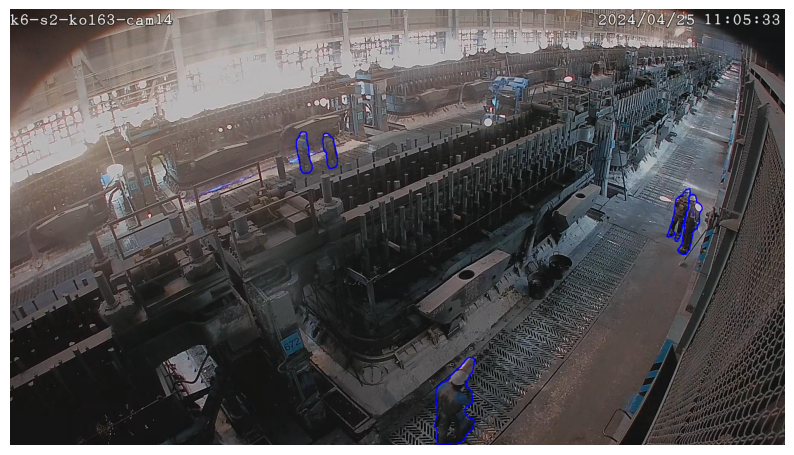

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_yolo_segmentation_annotations(image, annotations, img_width, img_height):
    """
    Рисует аннотации сегментации YOLO на изображении.

    Параметры:
        image (np.ndarray): Исходное изображение.
        annotations (list): Список аннотаций в формате YOLO сегментации.
        img_width (int): Ширина изображения.
        img_height (int): Высота изображения.
    """
    for annotation in annotations:
        # Разделяем аннотацию: первый элемент — class_id, остальные — координаты точек
        class_id = annotation[0]
        points = annotation[1:]

        # Преобразуем нормализованные координаты обратно в пиксели
        contour = []
        for i in range(0, len(points), 2):
            x = int(points[i] * img_width)
            y = int(points[i + 1] * img_height)
            contour.append([x, y])

        # Преобразуем в формат, подходящий для cv2.drawContours
        contour = np.array(contour, dtype=np.int32).reshape((-1, 1, 2))

        # Рисуем контур на изображении (цветом, например, красным)
        cv2.drawContours(image, [contour], -1, (255, 0, 0), 2)  # Красный цвет и толщина 2

    # Отображаем изображение с наложенными контурами
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Рисуем аннотации на изображении
draw_yolo_segmentation_annotations(image, annotations, img_width, img_height)